In [1]:
import sys, os, gc
import numpy as np
import pandas as pd
import tables

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

In [2]:
#!pip install --quiet tables

In [3]:
sys.path.append('../src/')
from utils import make_cite_train, make_cite_test

In [4]:
#kgl_input = '/kaggle/input'
#DATA_DIR = os.path.join(kgl_input, os.listdir(kgl_input)[0])
DATA_DIR = '../data'
os.listdir(DATA_DIR)

['train_cite_inputs.h5',
 'metadata_cite_day_2_donor_27678.csv',
 'test_cite_inputs_day_2_donor_27678.h5',
 'test_cite_inputs.h5',
 'tmp',
 'train_cite_targets.h5',
 'metadata.csv']

In [5]:
PATH_METADATA = os.path.join(DATA_DIR, 'metadata.csv')
PATH_TRAIN_CITE_INPUTS = os.path.join(DATA_DIR, 'train_cite_inputs.h5')
PATH_TRAIN_CITE_TARGETS = os.path.join(DATA_DIR, 'train_cite_targets.h5')

PATH_METADATA2 = os.path.join(DATA_DIR, 'metadata_cite_day_2_donor_27678.csv')
PATH_TEST_CITE_INPUTS = os.path.join(DATA_DIR, 'test_cite_inputs.h5')
PATH_TEST_CITE_INPUTS2 = os.path.join(DATA_DIR, 'test_cite_inputs_day_2_donor_27678.h5')

In [6]:
x_train, y_train, meta_train = make_cite_train(PATH_TRAIN_CITE_INPUTS, PATH_TRAIN_CITE_TARGETS, PATH_METADATA)
gc.collect()

58

In [7]:
x_test, meta_test = make_cite_test(PATH_TEST_CITE_INPUTS, PATH_TEST_CITE_INPUTS2, PATH_METADATA, PATH_METADATA2)
gc.collect()

0

In [8]:
meta_all = pd.concat([meta_train, meta_test])

## Explore evolution of cell types for different donors

In [9]:
mtx = meta_all[meta_all.cell_type != 'hidden'][['donor', 'day', 'cell_type']]
mtx = mtx.value_counts().reset_index().rename(columns={0: 'counts'})
mtx['frac'] = mtx.groupby(['donor', 'day']).counts.transform(lambda x: x/np.sum(x))
mtx.sort_values(by=['donor', 'day']).head(7)
gc.collect()
mtx.head()

,donor,day,cell_type,counts,frac
0,31800,2,HSC,4078,0.485765
1,13176,3,HSC,3631,0.475075
2,32606,2,HSC,3544,0.474050
3,31800,4,HSC,3366,0.331658
4,32606,4,HSC,3131,0.329198


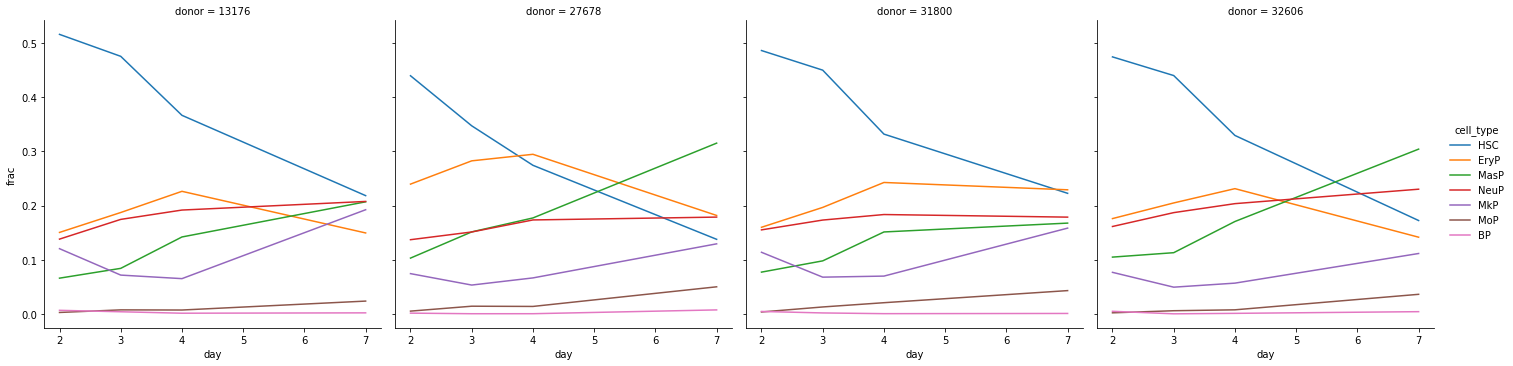

In [10]:
sns.relplot(data=mtx, x='day', y='frac', hue='cell_type', col='donor', kind='line')

Stem cells (HSC) are converted to progenitor (P) cells, which may be in turn converted to other cells not included in the analysis. The relative fraction of HSCs decreases, while P cells increase and the same trend can be observed in total counts. It is not clear from the fractions plot whether EryP cells go through a maximum at day 4 because they are converted to other types of cells or because other P cells rise in later days. The total count plots indicate that the P cell totals drop on day 7.

Interestingly, the cell_type labels are also included for all donors in Citeseq even in the private test day 7.
Multiome data exclude one donor and do not provide reference for the test day 10.

The cell type information (while imprecise) may provide some auxiliary information (needs to be tested by trying with and withoug). It could be used for filtering out donor specific biases in the data, such as expression different genes that is not related to the cell differentiation but rather to donor-specific genotype.

The correlation between Citeseq and Multiome cell fractions looks alright and could be used to predict averages for donor 27678 and days 1-7 for the Multiome dataset. Not sure that would help anything, though.

Domain knowledge about the fate of progenitor cells could help here to clarify whether they are converted to new cells or we just observe lower counts before the experimental setup.

Can we try to predict relative Multiome cell type fractions for day 10 usig simple reaction constants? That could help set priors on cell classification if we use classification 

**Get protein statistics**

In [11]:
protein = pd.merge(y_train, meta_train[['cell_type', 'donor', 'day']], left_index=True, right_index=True)
protein.head()

,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224,cell_type,donor,day
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070,HSC,32606,2
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063,HSC,32606,2
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600,EryP,32606,2
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671,NeuP,32606,2
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445,EryP,32606,2


['CD7' 'CD41' 'CD112' 'HLA-A-B-C' 'CD4' 'IgM' 'Rat-IgG2a' 'CD88' 'CD31'
 'CD161' 'CD115' 'CD95' 'CD33' 'Mouse-IgG2a' 'Rat-IgG2a' 'CD272' 'CD195'
 'CD278' 'CD134' 'CD62L']
['HSC', 'EryP', 'NeuP', 'MasP', 'MkP', 'BP', 'MoP']


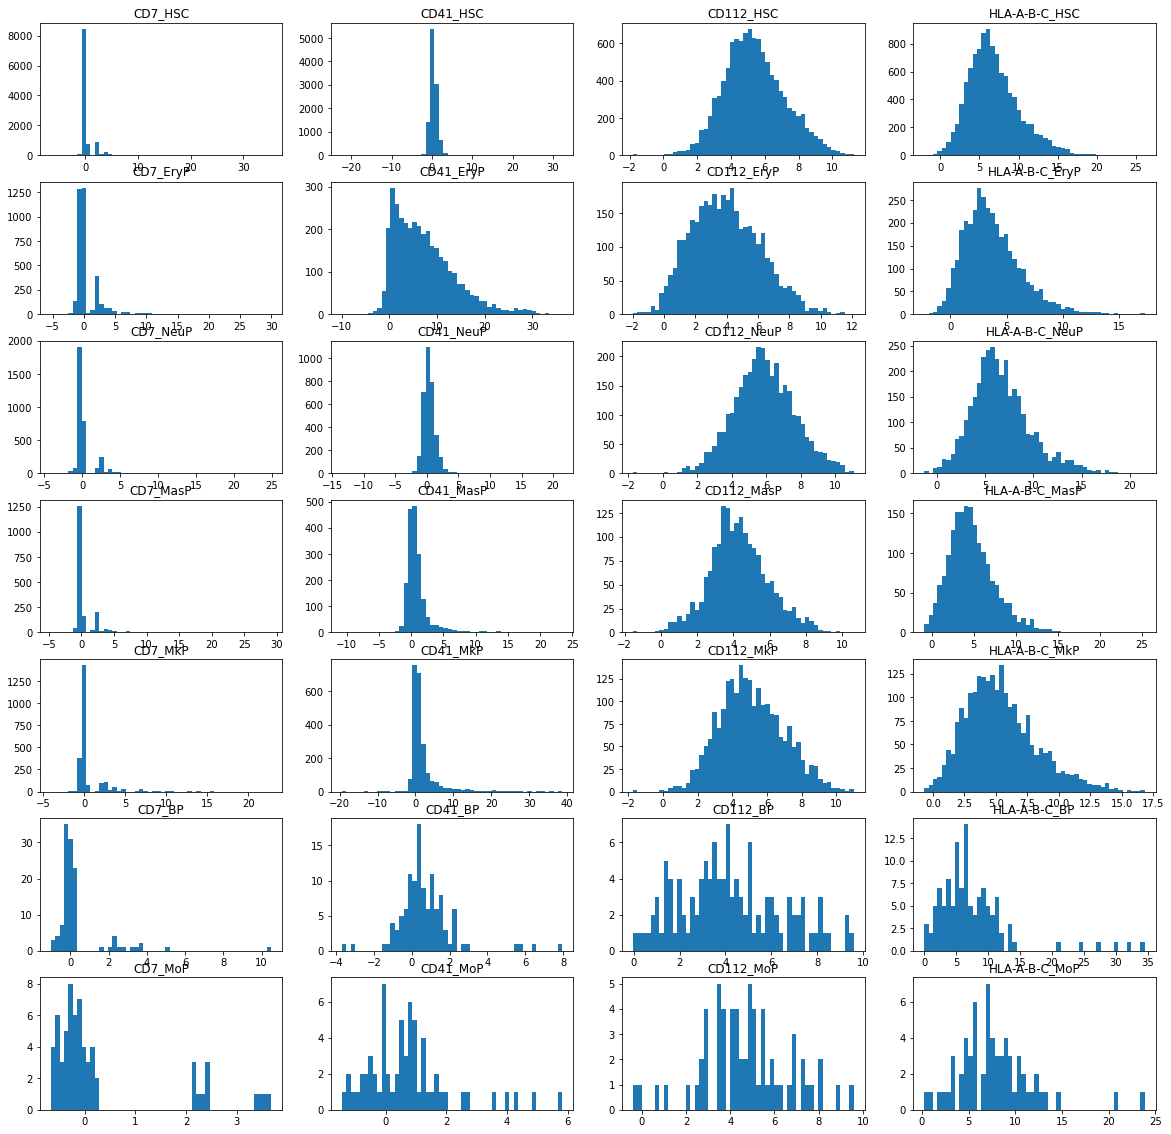

In [12]:
# Distribution of different proteins across cells1
cnames = y_train.columns.values
cnames = np.random.choice(cnames, 20)
print(cnames)
#cnames[0:3] = ['CD38', 'CD34', 'CD10']

tnames = list(protein['cell_type'].unique())
print(tnames)


_, axs = plt.subplots(7, 4, figsize=(20,20))
#axs = axs.ravel()
for i, t in enumerate(tnames):
    for j in range(4):
        _ = axs[i,j].hist(protein[(protein.cell_type == t) & (protein.day == 2)][cnames[j]], 50)
        _ = axs[i,j].set_title(cnames[j] + '_' + t)

['CD328' 'CD319' 'CD224' 'FceRIa' 'CD314' 'CD44' 'CD29' 'CD224' 'CD163'
 'CD85j' 'CD5' 'CD196' 'CD44' 'CD41' 'CD158' 'CD192' 'Mouse-IgG2b' 'CD11c'
 'CD1c' 'CD40']
['HSC', 'EryP', 'NeuP', 'MasP', 'MkP', 'BP', 'MoP']


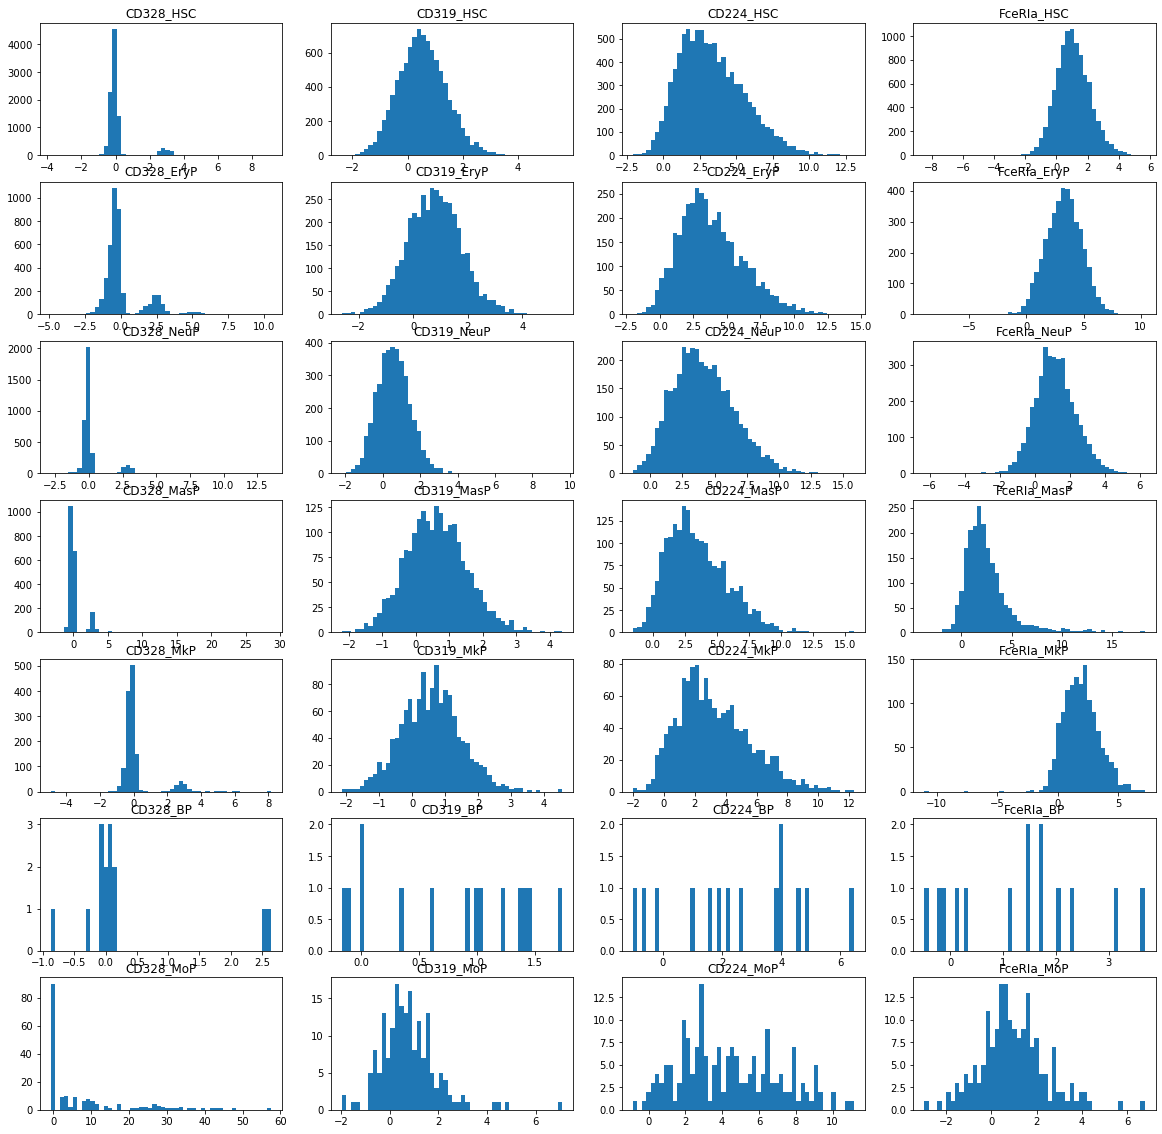

In [13]:
# Distribution of different proteins across cells1
cnames = y_train.columns.values
cnames = np.random.choice(cnames, 20)
print(cnames)
#cnames[0:3] = ['CD38', 'CD34', 'CD10']

tnames = list(protein['cell_type'].unique())
print(tnames)


_, axs = plt.subplots(7, 4, figsize=(20,20))
#axs = axs.ravel()
for i, t in enumerate(tnames):
    for j in range(4):
        _ = axs[i,j].hist(protein[(protein.cell_type == t) & (protein.day == 3)][cnames[j]], 50)
        _ = axs[i,j].set_title(cnames[j] + '_' + t)

['Mouse-IgG1' 'CD158b' 'CD39' 'CD328' 'CD226' 'CD44' 'CD25' 'CD42b'
 'CD152' 'CD81' 'CD82' 'CD172a' 'TCR' 'CD85j' 'CD29' 'CD69' 'CD45'
 'Mouse-IgG2b' 'CD13' 'TCRVd2']
['HSC', 'EryP', 'NeuP', 'MasP', 'MkP', 'BP', 'MoP']


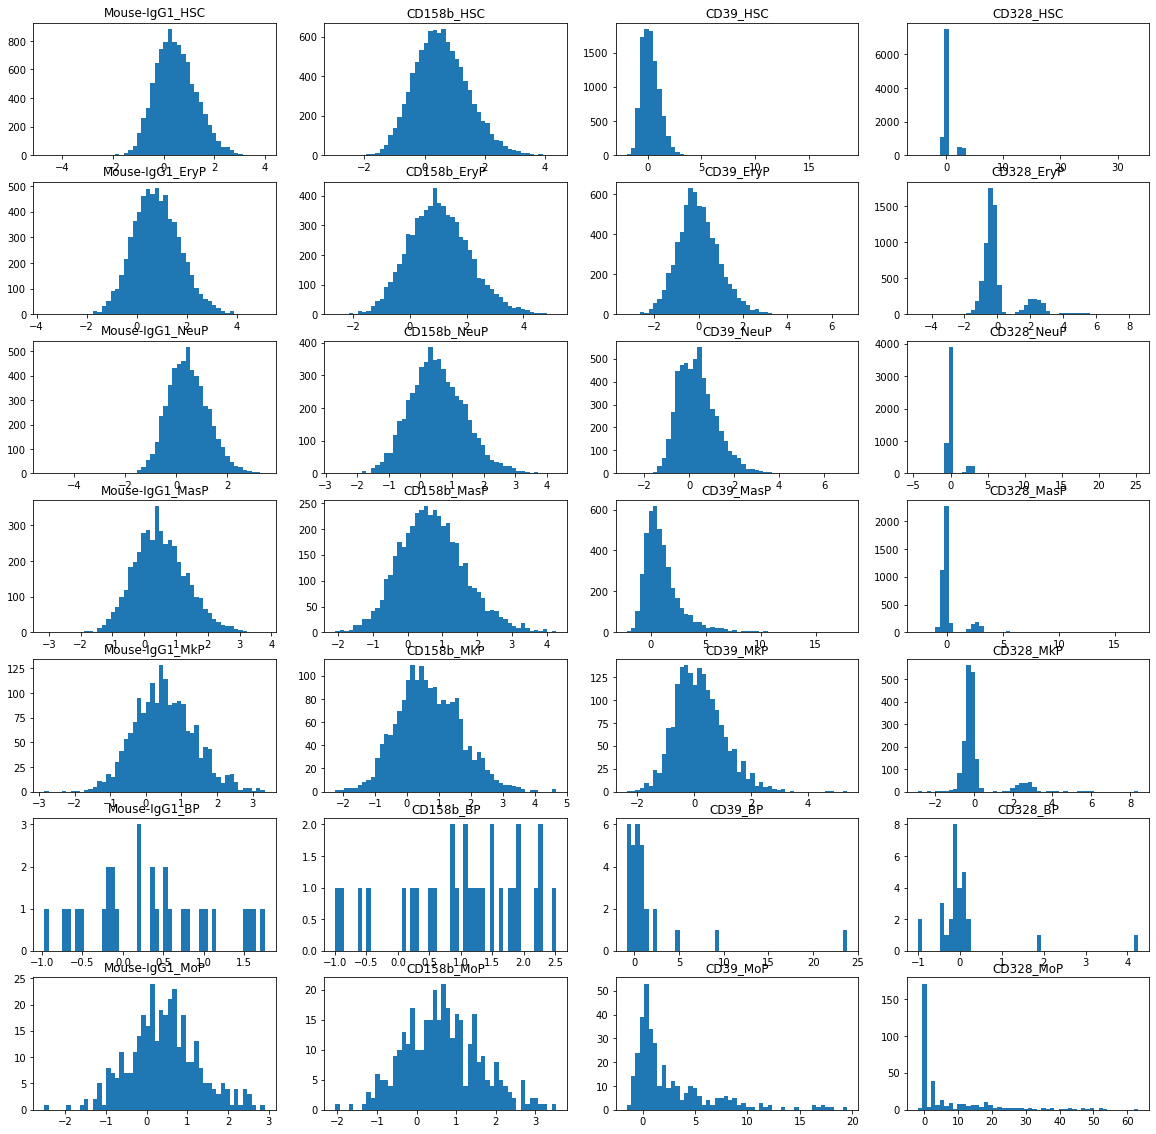

In [14]:
# Distribution of different proteins across cells1
cnames = y_train.columns.values
cnames = np.random.choice(cnames, 20)
print(cnames)
#cnames[0:3] = ['CD38', 'CD34', 'CD10']

tnames = list(protein['cell_type'].unique())
print(tnames)


_, axs = plt.subplots(7, 4, figsize=(20,20))
#axs = axs.ravel()
for i, t in enumerate(tnames):
    for j in range(4):
        _ = axs[i,j].hist(protein[(protein.cell_type == t) & (protein.day == 4)][cnames[j]], 50)
        _ = axs[i,j].set_title(cnames[j] + '_' + t)

In [15]:
protein[(protein.cell_type == t) & (protein.day == 4)].iloc[2].values[:-4].shape

(139,)

<BarContainer object of 139 artists>

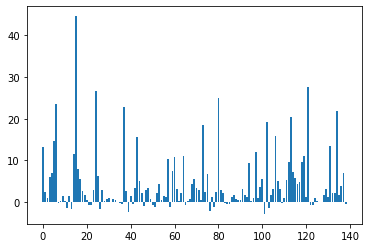

In [16]:
plt.bar(range(139), protein[(protein.cell_type == t) & (protein.day == 4)].iloc[2].values[:-4])

In [17]:
pagg = protein.groupby(['donor', 'day', 'cell_type']).mean().sort_index(level=0, sort_remaining=True)
pagg.reset_index(inplace=True)

In [18]:
pagg.head(21)

,donor,day,cell_type,CD86,CD274,CD270,CD155,CD112,CD47,CD48,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
0,13176,2,BP,2.636741,0.564040,1.816194,5.920872,5.343722,10.821576,11.385071,...,0.078519,6.746574,1.794369,0.320703,0.786281,2.031155,7.467514,2.658229,3.176197,4.446934
1,13176,2,EryP,0.192372,0.939601,1.870991,7.158249,5.555902,6.078429,0.342321,...,0.459102,8.494985,2.422138,0.359772,0.222545,1.613440,8.911075,0.574694,9.377619,5.526514
2,13176,2,HSC,0.450577,0.673280,1.504474,7.964923,6.872005,10.407454,4.370047,...,0.476525,7.481881,1.176183,0.559365,0.244908,1.508502,6.301435,0.753817,3.769365,5.748641
3,13176,2,MasP,0.412391,0.731564,1.566143,7.973290,5.768622,9.138628,3.272089,...,0.527494,10.678103,1.388240,0.548791,0.449375,1.462920,8.858335,0.812244,6.220553,5.162668
4,13176,2,MkP,0.421319,0.698082,1.449083,7.436174,6.572208,7.258233,1.003075,...,0.554012,7.154218,1.324284,0.513191,0.277807,1.467081,7.990234,0.627706,5.240887,5.089325
5,13176,2,MoP,3.080137,1.098038,1.634274,7.734607,5.603288,10.768185,18.637634,...,1.073302,9.310496,1.357461,0.759344,9.760821,1.791185,5.520913,5.851771,3.158412,6.183075
6,13176,2,NeuP,0.813250,0.787059,1.476531,8.703132,7.300712,9.935406,10.612761,...,0.726470,10.940707,1.132094,0.755064,0.422480,1.519664,4.745774,1.176009,4.752108,5.755896
7,13176,3,EryP,0.345634,1.211187,1.430778,6.837110,5.412724,6.348510,0.588607,...,0.486942,7.337370,2.076900,0.373034,0.248287,1.177701,7.661129,0.764911,7.835333,4.964296
8,13176,3,HSC,0.441964,0.763622,1.157229,7.402130,7.126904,10.160288,4.175175,...,0.432139,7.076400,0.989595,0.506340,0.219875,1.001389,5.270263,0.841671,3.148554,4.490560
9,13176,3,MasP,0.728466,0.757307,1.309525,8.714510,5.953220,9.795455,4.957766,...,0.456295,10.444128,1.215684,0.506722,0.362208,1.161194,9.392884,0.897719,5.526649,4.697790


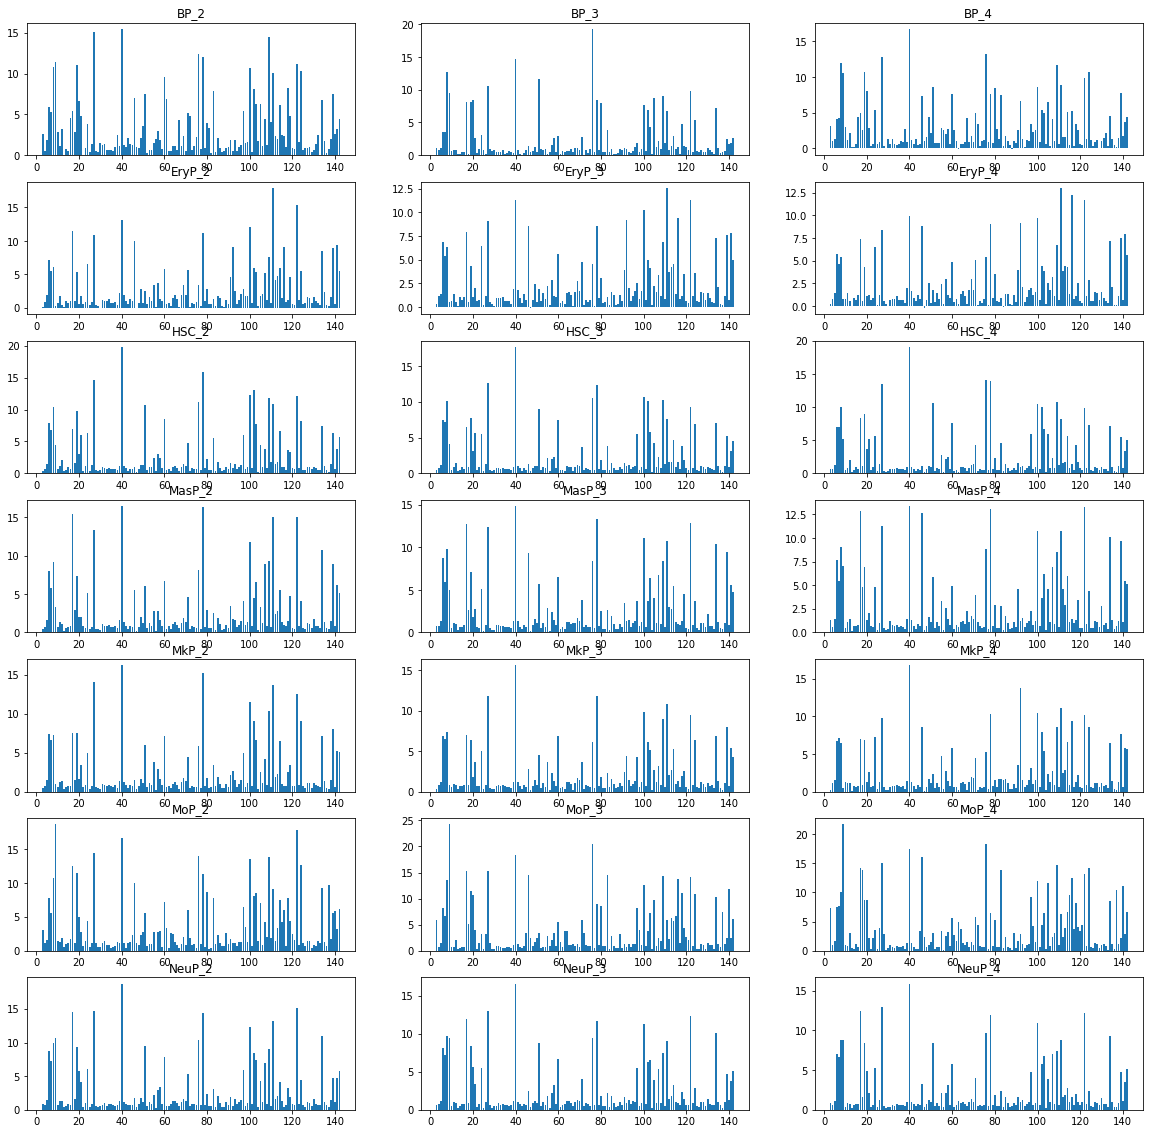

In [19]:
# Proteins detected in different cells
tnames = list(pagg['cell_type'].unique())
dnames = list(pagg['day'].unique())

_, axs = plt.subplots(7, 3, figsize=(20,20))
#axs = axs.ravel()
for i, t in enumerate(tnames):
    for j, d in enumerate(dnames):
        #print(i, t, j)
        #_ = axs[i,j].bar(range(y_train.shape[1]), y_train.iloc[cells[i]])
        _ = axs[i,j].bar(range(3, pagg.shape[1]), pagg[(pagg.cell_type == t) & (pagg.day == d)].iloc[0][3:])
        _ = axs[i,j].set_title(t + '_' + str(d))

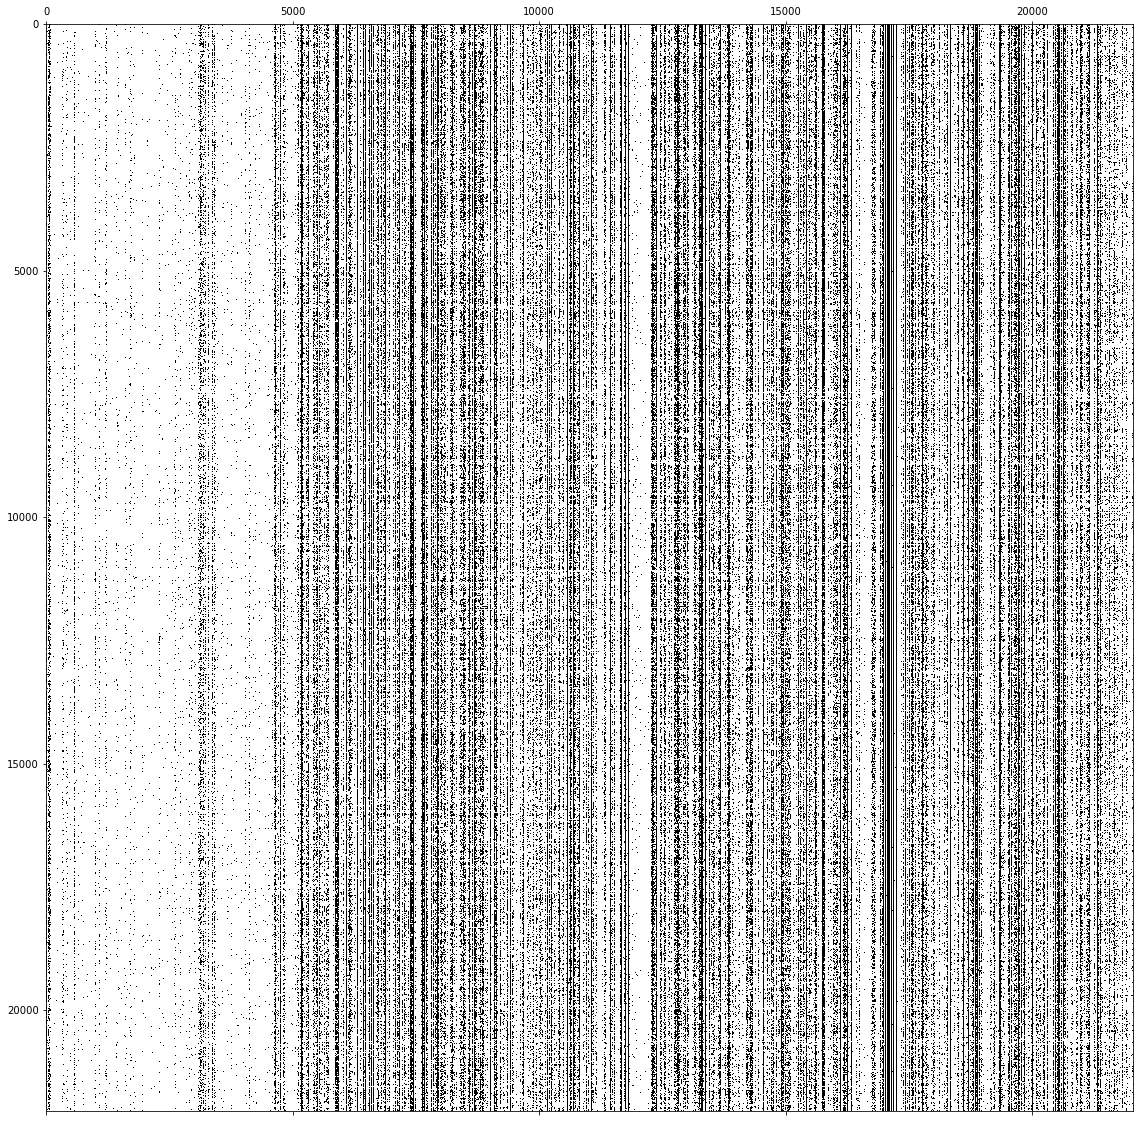

In [20]:
plt.figure(figsize=(20, 20))
plt.spy(x_train[:22050])
plt.show()

In [21]:
np.sum(x_train.sum(axis=0) == 0)

449

In [22]:
newcols = list(set(x_test.columns) - set(x_train.columns))
x_train[newcols] = 0.
x_all = pd.concat([x_train, x_test])
gc.collect()

2516

In [23]:
np.sum(x_all.sum(axis=0) == 0)

0

In [24]:
#x_all.to_pickle('../data/tmp/x_all.pickle')

In [ ]:
x_all.to_hdf('../data/tmp/x_all.h5', key='x_all', mode='w')